# หาพารามิเตอร์ของ Prophet เพื่อใช้ทำนายปริมาณผลผลิตสินค้าเกษตร

https://facebook.github.io/prophet/docs/quick_start.html

In [1]:
import numpy as np
import pandas as pd

import os
import itertools
from tqdm import tqdm
tqdm.pandas()

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, nb_workers=4, use_memory_fs=False)

import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

from utils.preprocess import read_yield, read_annually_data, read_month_data, read_month_data_area, add_regressor

py.init_notebook_mode(connected=True)

import datetime
from dateutil.relativedelta import relativedelta

from config import params 

eps = 1e-16

import warnings
warnings.filterwarnings("ignore")

/home/yoyo/anaconda3/envs/oae/lib/python3.8/site-packages/tqdm/std.py:706: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


## User Parameters

In [2]:
print(list(params.keys()))

['rice_in-season', 'rubber', 'rice_off-season', 'palm', 'coffee', 'corn', 'cassava', 'longan', 'durian', 'pineapple', 'rambutan', 'mangosteen', 'cane', 'coconut']


In [3]:
ptype = 'rubber'
param = params[ptype]
yield_file = param['yield_file']
cost_file = param['cost_file']
price_file = param['price_file']
is_harvest_season = param['harvest']
col_price = param['col_price']

In [4]:
param_en = {
    'rubber' : datetime.datetime(2014, 12, 1),
#     'palm' : datetime.datetime(2020, 12, 1),
    'durian' : datetime.datetime(2017, 12, 1),
    'rambutan' : datetime.datetime(2017, 12, 1),
#     'mangosteen' : datetime.datetime(2018, 12, 1)
}

In [5]:
param_st = {
    'rubber' : datetime.datetime(2009, 1, 1),
    'cane' : datetime.datetime(2010, 1, 1),
    'coconut' : datetime.datetime(2015, 1, 1)
}

In [6]:
st_date = param_st.get(ptype, datetime.datetime(2012, 1, 1))
en_date = param_en.get(ptype, None)

### Find good test data

In [7]:
df, _ = read_yield(yield_file, st=st_date, en=en_date)

In [8]:
st = df['date'].max() + relativedelta(months=-12)

In [9]:
df[df['date']>st]['date'].min(), df[df['date']>st]['date'].max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2014-12-01 00:00:00'))

In [10]:
df_group = df[df['date']>st].groupby(['province_en']).sum().sort_values(by='value', ascending=False)[['value']]

In [11]:
N = np.where((df_group.cumsum() / df_group.sum()) >= .8)[0][0]
N

13

In [12]:
f"Percentage of training data: {df_group[:N+1]['value'].sum() / df_group['value'].sum():.3f}"

'Percentage of training data: 0.800'

In [13]:
df_group[:N+1]

,value
province_en,
Surat Thani,636908.0
Songkhla,455286.0
Nakhon Si Thammarat,449557.1
Trang,344965.0
Yala,295684.7
Narathiwat,227836.0
Krabi,196769.0
Phatthalung,183004.0
Phangnga,158702.0


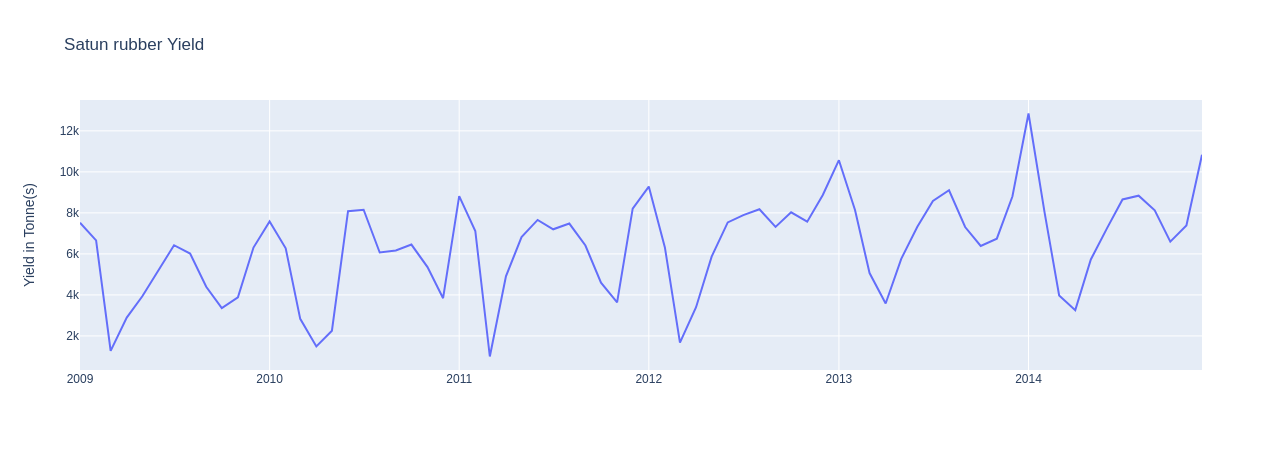

In [14]:
# area = df_group.iloc[N-1].name
area = df_group.iloc[N].name
_, _, df_area = read_yield(yield_file, area, st=st_date, en=en_date)

py.iplot({'data':go.Scatter(x=df_area['ds'], y=df_area['y'], name='y'),
         'layout':dict(title = area + " " + ptype + ' Yield',
                       yaxis = dict(title = 'Yield in Tonne(s)'))
         })

Read all data

In [15]:
df_cost = []
for cost_f in cost_file:
    df_cost.append(read_annually_data(cost_f))

precipitation_file = 'Clean13products/ปริมาณน้ำฝน - เขื่อน/ปริมาณฝนตก(RT2244)_clean.xlsx'
df_precip = pd.read_excel(precipitation_file)
df_precip['date'] = df_precip['date'].apply(lambda x: datetime.datetime(x.year-543, x.month, x.day))
df_precipitation = read_month_data_area(df_precip, area)

df_price = []
for price_f in price_file:
    df_price.append(read_month_data(price_f))

col_regressor = [f'cost{i+1}' for i in range(len(df_cost))] + ['precipitation'] + col_price
@add_regressor([*df_cost, df_precipitation, *df_price], col_regressor)
def add_features(df):
    return df

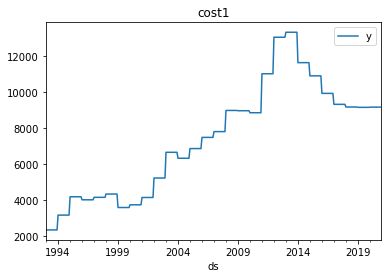

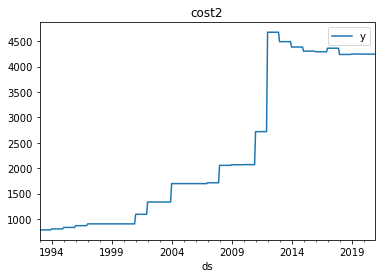

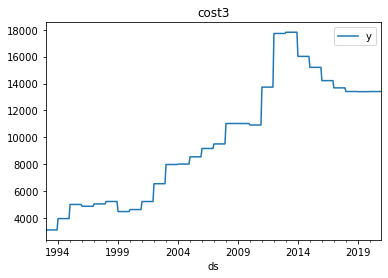

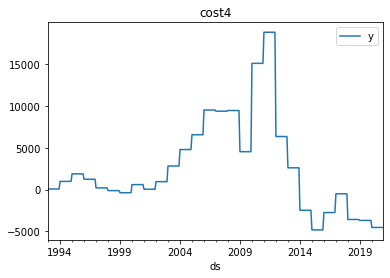

In [ ]:
for name, df_i in zip(col_regressor, [*df_cost, df_precipitation, *df_price]):
    try:
        df_i.plot(title=name)
    except:
        pass

### Grid Search Parameters

In [ ]:
param_grid = {
    'p': [0, 1, 2],
    'd': [0, 1],
    'q': [0, 1 ,2],
    'ps': [0, 1],
    'ds': [0, 1],
    'qs': [0, 1],
}

Generate all combinations of parameters

In [ ]:
df_params = pd.DataFrame([dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())])
df_params

# Tuning using Grid Search

In [ ]:
def all_provinces_predict(arg, areas):
#     print(arg)
    res = pd.DataFrame(columns = ['RMSE', 'MAE', 'AnnualErr', 'AVG', 'SUM', 'PredSUM', 'MonthErr'],
                       index = areas) 
    for province in areas:
        _, _, df_province = read_yield(yield_file, province, st=st_date, en=en_date)
        rmse, mae, aerr, gt_avg, gt_sum, pred_sum, _, _ = one_province_predict(df_province, arg)
        res.loc[province] = [rmse, mae, aerr, gt_avg, gt_sum, pred_sum, 100*mae/gt_avg]
    return res

In [ ]:
def one_province_predict(df_yield, arg):
    df_train, df_test = df_yield[:-12], df_yield[-12:]
    df_train = df_train.set_index('ds')
    df_train = df_train.resample('MS').asfreq()
    df_test = df_test.set_index('ds')
    df_test = df_test.resample('MS').asfreq() # frequency
    
    df_train = add_features(df_train).fillna(0)
    
    endog_col = df_train.columns[0]
#     exog_col = df_train.columns[1:]
#     print(endog_col)
#     print(exog_col, col_regressor)
#     print('endog columns:', endog_col, '\nexog columns:', exog_col)
    
    endog = df_train.loc[:, endog_col]
    exog = df_train.loc[:, col_regressor]
    
    df_train = df_train.sort_index() # sort
#     print(df_train)
    
    my_order = (arg['p'],arg['d'],arg['q'])
    my_seasonal_order = (arg['ps'], arg['ds'], arg['qs'], 12)
    # define model
    model = SARIMAX(endog=endog, exog=exog, order=my_order, seasonal_order=my_seasonal_order)

    try:
        model_fit = model.fit()
    except Exception as inst:
        print(type(inst))    # the exception instance
        print(inst)
        return None, None, None, None, None, None, None, None
#     print(model_fit.summary())
    
    df_test = df_test.sort_index()
    df_test = add_features(df_test).fillna(0)

    # exog_forecast = sm.add_constant(df_test.loc[:, ['cost', 'precipitation', 'rainday', 'price', 'on_season']])
    exog_forecast = df_test.loc[:, col_regressor]
    
#     print(exog_forecast)
    
    #get the predictions and residuals
    predictions = model_fit.forecast(len(exog_forecast), exog=exog_forecast)
    # predictions = pd.Series(predictions, index=df_test.index)
    predictions.index = exog_forecast.index
    predictions.clip(lower=0, inplace=True)
    
    assert(np.all(predictions.index.to_numpy() == df_test.index.to_numpy()))
    residuals = df_test['y'] - predictions
    
    mae = np.mean(np.abs(residuals))
    rmse = np.sqrt(np.mean(residuals**2))
    pred_sum = np.sum(predictions)
    gt_sum = np.sum(df_test['y'])
    gt_mean = df_test['y'].mean()
    total_error = abs(1 - (pred_sum / (gt_sum+eps))) * 100
    
    return rmse, mae, total_error, gt_mean, gt_sum, pred_sum, model_fit, predictions

In [ ]:
province = df_group.index[N]
_, _, df_province = read_yield(yield_file, province, st=st_date, en=en_date)
rmse, mae, aerr, gt_avg, gt_sum, pred_sum, model, predictions = one_province_predict(df_province, {'p':1, 'd':0, 'q':1, 'ps':0, 'ds':1, 'qs':0})

print(province)
print('RMSE: %.2f' % rmse )
print('MAE: %.2f' % mae )
print(f"Total Error: {aerr:.3f} %")
print(f"Monthly Error: {100*mae/gt_avg:.3f} %")
print(f'AVG: {gt_avg:.3f}')
print(f'SUM: {gt_sum:.3f}')
print(f'PredSUM: {pred_sum:.3f}')

print(model.summary())

py.iplot([
    go.Scatter(x=df_province['ds'], y=df_province['y'], name='train', line=dict(width=3)),
    go.Scatter(x=predictions.index, y=predictions, name='yhat', line=dict(width=3)),
])

In [ ]:
# df_params.iloc[0]
# all_provinces_predict(df_params.iloc[0], df_group.index[:N+1])

In [ ]:
res = df_params.progress_apply(lambda x: all_provinces_predict(x, df_group.index[:N+1]), axis=1)
# %time res = df_params.parallel_apply(lambda x: all_provinces_predict(x, df_group.index[:N+1]), axis=1)

Get overall results

In [ ]:
overview = df_params.merge(pd.concat([t.mean() for t in res], axis=1).T, 
                           left_index=True, 
                           right_index=True, 
                           validate="one_to_one")

In [ ]:
overview_std = df_params.merge(pd.concat([t.std() for t in res], axis=1).T, 
                           left_index=True, 
                           right_index=True, 
                           validate="one_to_one")

In [ ]:
minidx = overview['MAE'].idxmin()

Save result to Excel file

In [ ]:
os.makedirs('./outputs/sarimax/', exist_ok = True)

with pd.ExcelWriter('./outputs/sarimax/' + ptype + '_output.xlsx') as writer:
    overview.iloc[minidx].to_excel(writer, sheet_name='best_param')
    overview.to_excel(writer, sheet_name='mean')
    overview_std.to_excel(writer, sheet_name='std')
    for i,t in enumerate(res):
        t.to_excel(writer, sheet_name=f'{i}')  

In [ ]:
overview

In [ ]:
overview.iloc[minidx]

In [ ]:
r = all_provinces_predict(df_params.iloc[0], df_group.index[:N])